In [2]:
import pandas as pd

file_path = 'fact_checks_final.csv'
data = pd.read_csv(file_path)

data.head()

data_filtered = data[~data['judge'].isin(['판단 유보', '절반의 사실'])]

data_filtered['judge'] = data_filtered['judge'].replace({'전혀 사실 아님': '거짓',
                                                         '대체로 사실 아님': '거짓',
                                                         '대체로 사실': '사실',
                                                         '사실': '사실'})
data_filtered['judge'].value_counts()

<ipython-input-2-ebf3ae366455>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['judge'] = data_filtered['judge'].replace({'전혀 사실 아님': '거짓',


거짓    2755
사실    1036
Name: judge, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

X = data_filtered['title']
y = data_filtered['judge']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF 벡터화와 로지스틱 회귀를 사용한 파이프라인 생성
model = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=42))

model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report


(0.7272727272727273,
 '              precision    recall  f1-score   support\n\n          거짓       0.73      0.99      0.84       551\n          사실       0.57      0.02      0.04       208\n\n    accuracy                           0.73       759\n   macro avg       0.65      0.51      0.44       759\nweighted avg       0.69      0.73      0.62       759\n')

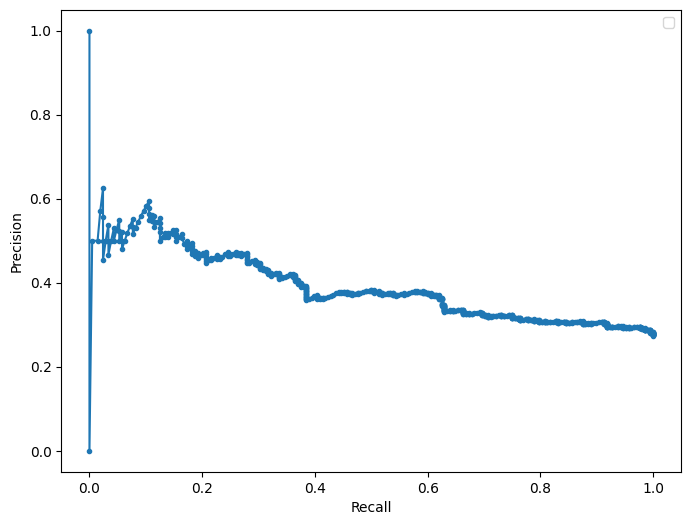

0.6208239564251629

In [8]:
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt

# f1 스코어 계산
f1 = f1_score(y_test, y_pred, average='weighted')

# 정밀도-재현율 곡선 계산
precision, recall, _ = precision_recall_curve(y_test, model.decision_function(X_test), pos_label='사실')

# 정밀도-재현율 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

f1


In [9]:
# 필요한 라이브러리 재로딩
import pandas as pd

# 데이터 파일 재로딩
file_path = 'fact_checks_final.csv'
data = pd.read_csv(file_path)

# 날짜 형식 변환
data['date'] = pd.to_datetime(data['date'], format='%Y.%m.%d')

# 시계열 정렬
data_sorted = data.sort_values('date')

# 날짜별로 데이터 집계 (예: 각 날짜별 레코드 수)
data_aggregated = data_sorted.groupby('date').size()

data_aggregated.head()

date
2017-03-29    6
2017-03-31    3
2017-04-03    1
2017-04-04    2
2017-04-05    1
dtype: int64

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

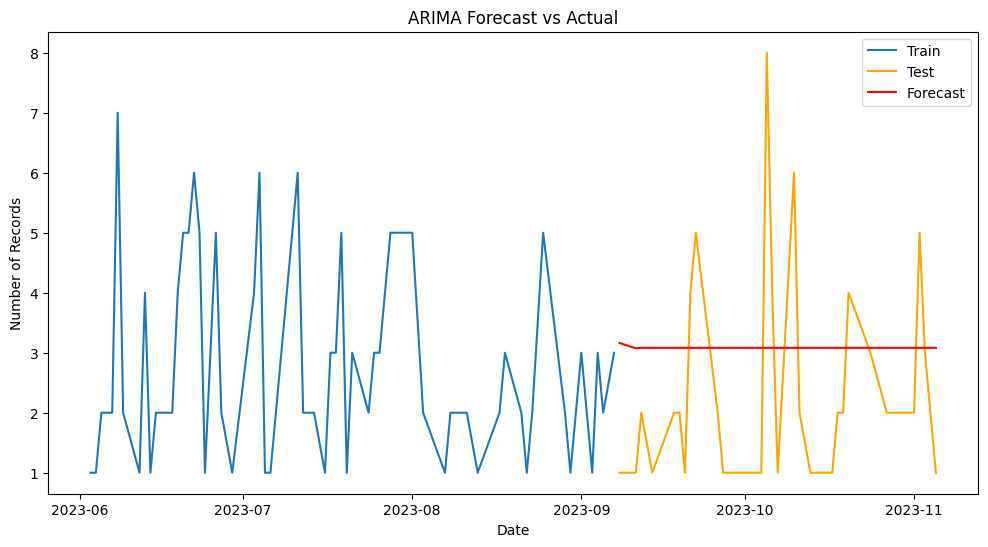

MSE: 3.408945142369059, RMSE: 1.8463328904531433, MAE: 1.6124027053834327


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error


train = data_aggregated[:-30]
test = data_aggregated[-30:]

model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(12, 6))
plt.plot(train.index[-60:], train[-60:], label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Number of Records")
plt.legend()
plt.show()

mse = mean_squared_error(test, forecast)

rmse = np.sqrt(mse)

mae = mean_absolute_error(test, forecast)

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")


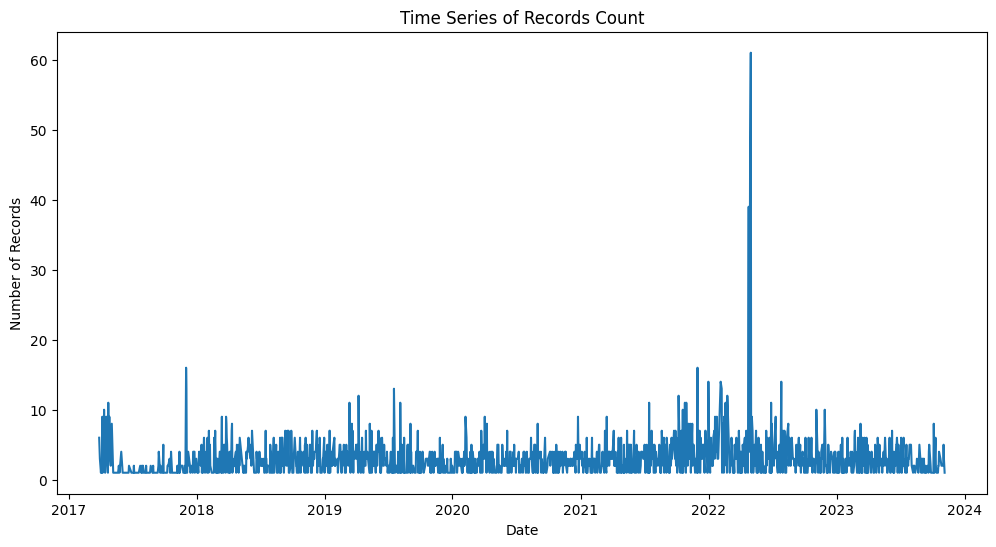

{'ADF Statistic': -13.690580066640306,
 'p-value': 1.346365005259544e-25,
 'Critical Values': {'1%': -3.4345813803729857,
  '5%': -2.863408896544693,
  '10%': -2.567764970671501}}

In [19]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 시계열 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(data_aggregated)
plt.title("Time Series of Records Count")
plt.xlabel("Date")
plt.ylabel("Number of Records")
plt.show()

# ADF 테스트 수행
adf_test = adfuller(data_aggregated)

adf_test_results = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}

adf_test_results
